# Stochastic model

In [186]:
import numpy as np
import matplotlib.pyplot as plt
import math


In [187]:
#open the meteorological data
import pandas as pd
meteo_df = pd.read_csv('../Data/meteo_tetiaroa_resampled.csv')
print("Columns in meteo_df:", meteo_df.columns)
#remove nan in precip
meteo_df = meteo_df.dropna(subset=['precip', 'precip1', 'precip2', 'precip4', 'UM', 'TM', 'date', 'time'])
precip_data = meteo_df['precip'].values
precip1_data = meteo_df['precip1'].values
precip2_data = meteo_df['precip2'].values
precip4_data = meteo_df['precip4'].values
hum_data = meteo_df['UM'].values
temperature_data = meteo_df['TM'].values
dates_data = meteo_df['date'].values
dates_dt = pd.to_datetime(dates_data)
time_data = meteo_df['time'].values

Columns in meteo_df: Index(['date', 'time', 'TM', 'precip', 'precip1', 'precip2', 'precip4', 'UM'], dtype='object')


In [188]:
mean_rain = np.mean(precip_data)
max_rain = np.max(precip_data)
print("Mean Rain:", mean_rain)
print("Max Rain:", max_rain)

Mean Rain: 4.577979295358808
Max Rain: 125.3


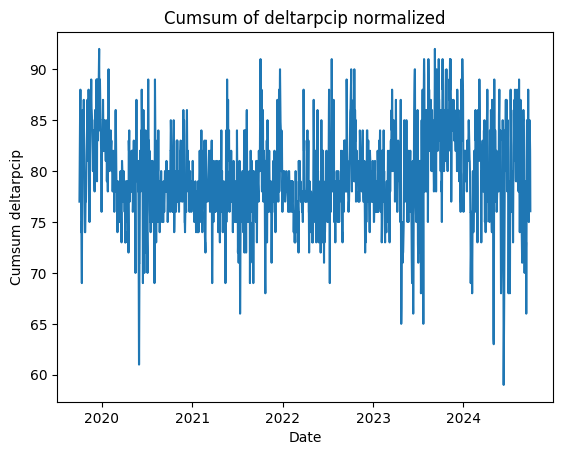

In [189]:
plt.plot(dates_dt, hum_data)
plt.title("Cumsum of deltarpcip normalized")
plt.ylabel("Cumsum deltarpcip")
plt.xlabel("Date")
plt.show()

In [190]:
Precmax = np.max(precip_data)
deltaprecip = 0.00001 * (25 + temperature_data ** 2) * (100 - hum_data)
# Cumsum of the deltaprecip normalized by Precmax, where value minimum is 0 and maximum is Precmax
H = np.zeros_like(precip_data)
H[0] = mean_rain*6
for i in range(1, len(precip_data)):
    H[i] = min(max_rain, max(0, H[i-1] + precip_data[i] - deltaprecip[i]))

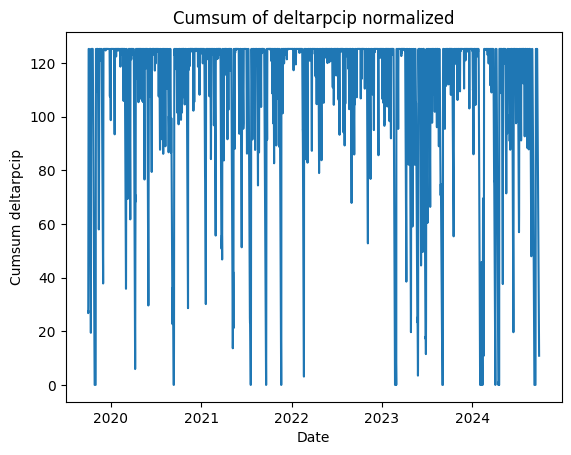

In [191]:
plt.plot(dates_dt, H)
plt.title("Cumsum of deltarpcip normalized")
plt.ylabel("Cumsum deltarpcip")
plt.xlabel("Date")
plt.show()

The following models will need the same rates and functions for events. Here, the temperature and rainfall dependencies only account for the competition in the larval stage.

In [192]:
def allee(M, Ms):
    return (0.1 *M + 0.01 *Ms) / (1 + 0.1 *M + 0.01 * Ms)

def allee2(M, Ms):
    return 1 - np.exp(-0.05 *(M + 0.1 *Ms))

def release1(M, n):
    return n*M + 2000

def competition1(K0, Kh, precip):
    return 1/(K0 + Kh *  precip)

def competition2( R0, Rmax, K0, Kh, precip, temp, hum, k = 1):
    delta_rain = precip + k * (25+ temp**2) * (100 - hum)
    rain = max(0, min(R0 + delta_rain, Rmax))/Rmax
    return Kh * rain + K0

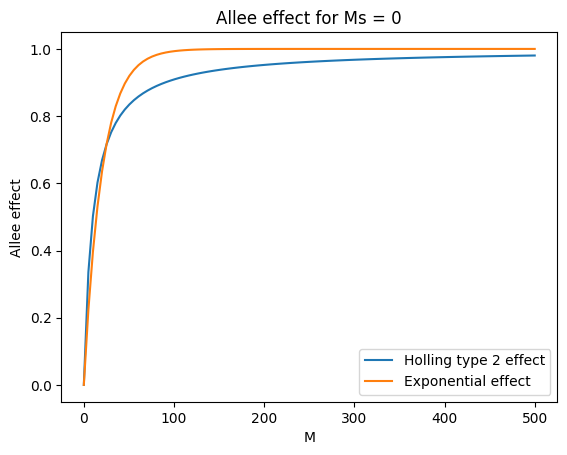

In [193]:
#plot allee for Ms = 0 and M from 0 to 1000
M = np.linspace(0, 500, 100)
plt.plot(M, allee(M, 0), label="Holling type 2 effect")
plt.plot(M, allee2(M, 0), label="Exponential effect")
plt.title("Allee effect for Ms = 0")
plt.ylabel("Allee effect")
plt.xlabel("M")
plt.legend()
plt.show()

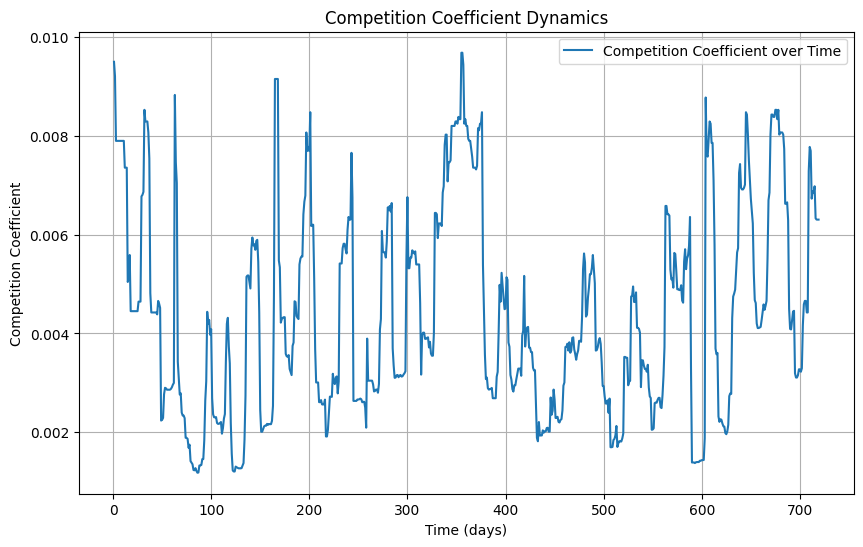

In [194]:
#plot the competition through time
comp_history = []
c = 0.01
T_max = 720
for t in range(1, T_max):
    precip = np.interp(t, time_data, precip2_data)
    comp = competition1(1/c, 1/(c*30), precip)
    comp_history.append(comp)

plt.figure(figsize=(10, 6))
plt.plot(range(1, T_max), comp_history, label='Competition Coefficient over Time')
plt.xlabel('Time (days)')
plt.ylabel('Competition Coefficient')
plt.title('Competition Coefficient Dynamics')
plt.legend()
plt.grid()
plt.show()

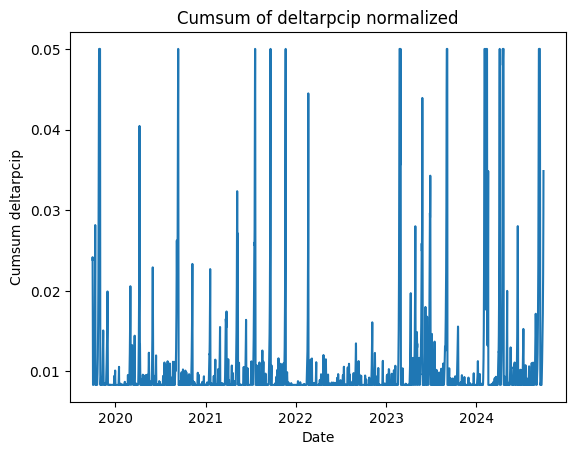

In [195]:
plt.plot(dates_dt, 1/((  1 /(c) * H / (max_rain) + 1/ (5 *c))))
plt.title("Cumsum of deltarpcip normalized")
plt.ylabel("Cumsum deltarpcip")
plt.xlabel("Date")
plt.show()

In [196]:
init_egg = 10000  # Starting egg population
init_l = 1000 # Starting larval population
init_p = 1000 # Starting pupal population
init_f0 = 100 # Starting female population
init_ff = 1200 # Starting fertilised female pop
init_fs = 0 # Starting strerile female pop
init_male = 400 # Starting adult population
init_sterile = 0 # Starting sterile male population
comp_larvae = 0.0001 # Competition coefficient for larvae
n_rel = 0
n_egg = 64

## Full mosquito life cycle

In [197]:
# Parameters
birth = 10/64  # Birth rate per adult
mu = 0.51    # rate at which egg becomes a female
egg_death = 0.046    # Death rate per egg
larva_death = 0.05   # Death rate per larva
pupa_death = 0.05   # Death rate per pupa
female_death = 0.046  # Death rate per adult
male_death = 0.139    # Death rate per adult
sterile_death = male_death*1.2   # Death rate per sterile
c = 0.01 # Competition coefficient for larvae
transi_el = 0.79
transi_lp = 0.125
transi_pa = 0.125
t=0.0

In [198]:
T_max = time_data[-1]
pop = [init_egg, init_l, init_p, init_f0, init_ff, init_fs, init_male, init_sterile]
time_history = [t]
population_history = [pop]

In [199]:
while t < T_max:
    # Step 1: Calculate total rate
    T = np.interp(t, time_data, temperature_data) + 273.15
    precip = np.interp(t, time_data, precip2_data)
    #T = temperature_const(t) # Uncomment this line to use constant temperature
    #water = np.interp(t, time_data, H)

    comp = competition1(1/c, 1/(c * 50), precip)
    #comp = 1 /((1 /(c) * water / (max_rain) + 1/(5 * c)))
    
    if pop[6] > 0:
        prob_M = pop[6]/(pop[6] + pop[7])
        prob_Ms = pop[7]/(pop[6] + pop[7])
    else:
        prob_M = 0
        prob_Ms = 0
        
    total_rate = (egg_death * pop[0]+
        (larva_death + comp * pop[1]) * pop[1] +
        pupa_death * pop[2] +
        female_death * (pop[3] + pop[4] + pop[5]) +
        male_death * pop[6] +
        sterile_death * pop[7] +  
        birth * pop[4] +
        transi_el * pop[0] +
        transi_lp * pop[1] +
        transi_pa * pop[2] +
        allee(pop[6], pop[7]) * prob_M * pop[3] +
        allee(pop[6], pop[7]) * prob_Ms * pop[3])
    
    if total_rate == 0:
        print("No life :(")
        break

    # Step 2: Draw time to next event
    time_to_next_event = np.random.exponential(1 / total_rate)
    t += time_to_next_event

    # Step 4: Determine the event
    p = np.random.rand() * total_rate
    s = (egg_death * pop[0]) / total_rate
    if p < (egg_death * pop[0]):
        pop[0] -= 1
    elif p < (egg_death * pop[0] + (larva_death + comp * pop[1]) * pop[1]) :
        pop[1] -= 1
    elif p < (egg_death * pop[0] + (larva_death + comp * pop[1]) * pop[1] + pupa_death * pop[2]):
        pop[2] -= 1
    elif p < (egg_death * pop[0] + (larva_death + comp * pop[1]) * pop[1] + pupa_death * pop[2] + female_death * pop[3]):
        pop[3] -= 1
    elif p < (egg_death * pop[0] + (larva_death + comp * pop[1]) * pop[1] + pupa_death * pop[2] + female_death * (pop[3] + pop[4])):
        pop[4] -= 1
    elif p < (egg_death * pop[0] + (larva_death + comp * pop[1]) * pop[1] + pupa_death * pop[2] + female_death * (pop[3] + pop[4] + pop[5])):
        pop[5] -= 1
    elif p < (egg_death * pop[0] + (larva_death + comp * pop[1]) * pop[1] + pupa_death * pop[2] + female_death * (pop[3] + pop[4] + pop[5]) + male_death * pop[6]):
        pop[6] -= 1
    elif p < (egg_death * pop[0] + (larva_death + comp * pop[1]) * pop[1] + pupa_death * pop[2] + female_death * (pop[3] + pop[4] + pop[5]) + male_death * pop[6] + sterile_death * pop[7]):
        pop[7] -= 1
    elif p < (egg_death * pop[0] + (larva_death + comp * pop[1]) * pop[1] + pupa_death * pop[2] + female_death * (pop[3] + pop[4] + pop[5]) + male_death * pop[6] + sterile_death * pop[7] + birth * pop[4]):
        pop[0] += n_egg
    elif p < (egg_death * pop[0] + (larva_death + comp * pop[1]) * pop[1] + pupa_death * pop[2] + female_death * (pop[3] + pop[4] + pop[5]) + male_death * pop[6] + sterile_death * pop[7] + birth * pop[4] + transi_el * pop[0]):
        pop[0] -= 1
        pop[1] += 1
    elif p < (egg_death * pop[0] + (larva_death + comp * pop[1]) * pop[1] + pupa_death * pop[2] + female_death * (pop[3] + pop[4] + pop[5]) + male_death * pop[6] + sterile_death * pop[7] + birth * pop[4] + transi_el * pop[0] + transi_lp * pop[1]):
        pop[1] -= 1
        pop[2] += 1
    elif p < (egg_death * pop[0] + (larva_death + comp * pop[1]) * pop[1] + pupa_death * pop[2] + female_death * (pop[3] + pop[4] + pop[5]) + male_death * pop[6] + sterile_death * pop[7] + birth * pop[4] + transi_el * pop[0] + transi_lp * pop[1] + 0.5 * transi_pa * pop[2]):
        pop[2] -= 1
        pop[6] += 1
    elif p < (egg_death * pop[0] + (larva_death + comp * pop[1]) * pop[1] + pupa_death * pop[2] + female_death * (pop[3] + pop[4] + pop[5]) + male_death * pop[6] + sterile_death * pop[7] + birth * pop[4] + transi_el * pop[0] + transi_lp * pop[1] + transi_pa * pop[2]):
        pop[2] -= 1
        pop[3] += 1
    
    elif p < (egg_death * pop[0] + (larva_death + comp * pop[1]) * pop[1] + pupa_death * pop[2] + female_death * (pop[3] + pop[4] + pop[5]) + male_death * pop[6] + sterile_death * pop[7] + birth * pop[4] + transi_el * pop[0] + transi_lp * pop[1] + transi_pa * pop[2] + allee(pop[6], pop[7]) * prob_M * pop[3]):
        pop[3] -= 1
        pop[4] += 1
    #elif p < (egg_death * pop[0] + larva_death * pop[1] + pupa_death * pop[2] + female_death * (pop[3] + pop[4] + pop[5]) + male_death * pop[6] + sterile_death * pop[7] + birth * pop[4] + transi_el * pop[0] + transi_lp * pop[1] + transi_pa * pop[2] + allee(pop[6], pop[7]) * prob_M * pop[3] + allee(pop[6], pop[7]) * prob_Ms * pop[3]):
    #elif p < (egg_death * pop[0] + larva_death * pop[1] + pupa_death * pop[2] + female_death * (pop[3] + pop[4] + pop[5]) + male_death * pop[6] + sterile_death * pop[7] + birth * pop[4] + transi_el * pop[0] + transi_lp * pop[1] + transi_pa * pop[2] + allee(pop[6], pop[7]) * prob_M * pop[3] + allee(pop[6], pop[7]) * prob_Ms * pop[3] + ):
    else :
        pop[3] -= 1
        pop[5] += 1
    
    # Step 3: Sterile insect release
    is_release_day = int(t) % 7 == 0
    is_new_day     = int(time_history[-1]) != int(t)
    enough_females = pop[4] + pop[5] > 30
    after_start    = t > 250
    releases_left  = n_rel < 20

    if is_release_day and is_new_day and enough_females and after_start and releases_left:
        nb = max(10000,release1(pop[6], 100))
        pop[7] += nb
        n_rel += 1
        print(f"Release {n_rel} at t={t:.2f}: {nb} sterile males")

    # Step 4: Record history
    time_history.append(t)
    population_history.append((pop[0], pop[1], pop[2], pop[3], pop[4], pop[5], pop[6], pop[7]))
    if sum(pop) == 0 or pop[4] + pop[5] == 0:
        print(f"No life at time {t:.2f}:(")
        break
    
    if min(pop) < 0:
        print(f"Negative population at time {t:.2f}:(")
        break


Release 1 at t=252.00: 58100 sterile males
Release 2 at t=259.00: 63200 sterile males
Release 3 at t=266.00: 58400 sterile males
Release 4 at t=273.00: 57400 sterile males
Release 5 at t=280.00: 45700 sterile males
Release 6 at t=287.00: 37200 sterile males
Release 7 at t=294.00: 33400 sterile males
Release 8 at t=301.00: 29800 sterile males
Release 9 at t=308.00: 24000 sterile males
Release 10 at t=315.00: 17100 sterile males
Release 11 at t=322.00: 17500 sterile males
Release 12 at t=329.00: 12700 sterile males
Release 13 at t=336.00: 10900 sterile males
Release 14 at t=343.00: 10000 sterile males
Release 15 at t=350.00: 10000 sterile males
Release 16 at t=357.00: 10000 sterile males
Release 17 at t=364.00: 10000 sterile males
Release 18 at t=371.00: 10000 sterile males
Release 19 at t=378.00: 10000 sterile males
Release 20 at t=385.00: 10000 sterile males


KeyboardInterrupt: 

In [169]:
len(time_history)

9918508

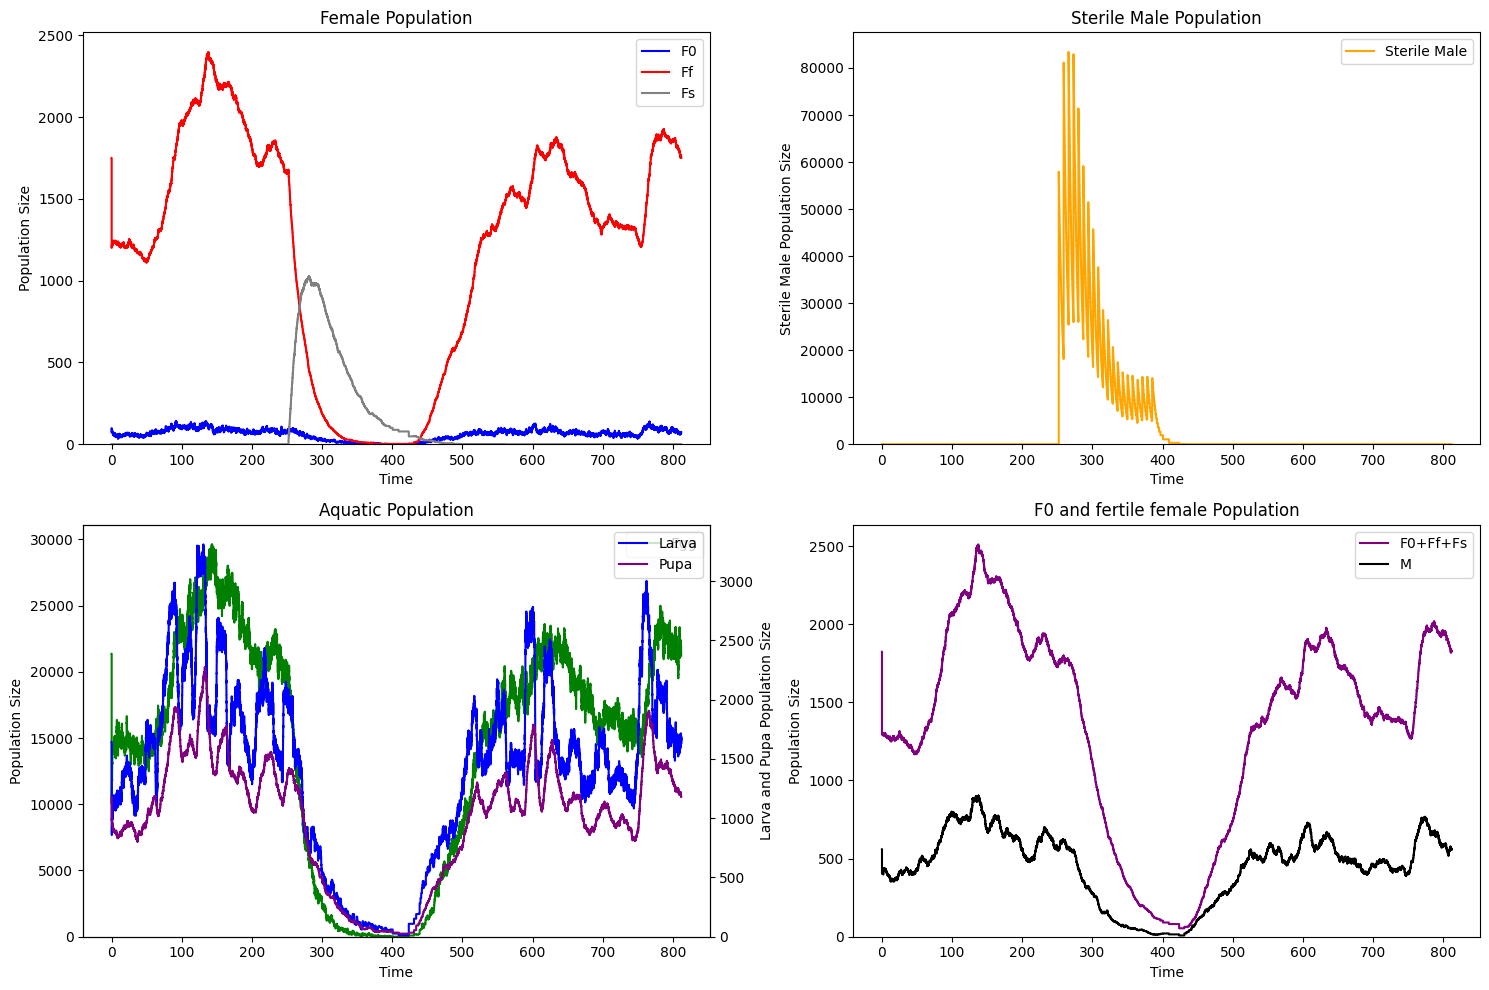

In [200]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
temp = np.interp(np.array(time_history), time_data, temperature_data)

# Sample every 10th point
step = 1000
time_sampled = time_history[::step]
pop_sampled = population_history[::step]

# Plot results for male and female population
axs[0, 0].step(time_sampled, [pop[3] for pop in pop_sampled], where="post", label='F0', color = 'blue')
axs[0, 0].step(time_sampled, [pop[4] for pop in pop_sampled], where="post", label='Ff', color = 'red')
axs[0, 0].step(time_sampled, [pop[5] for pop in pop_sampled], where="post", label='Fs', color = 'grey')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Population Size')
axs[0, 0].set_ylim(bottom=0)
axs[0, 0].set_title('Female Population')
axs[0, 0].legend()

# Plot results for sterile male population
axs[0, 1].step(time_sampled, [pop[7] for pop in pop_sampled], where="post", label='Sterile Male', color='orange')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Sterile Male Population Size')
axs[0, 1].set_ylim(bottom=0)
axs[0, 1].set_title('Sterile Male Population')
axs[0, 1].legend()

# Plot results for egg population
axs[1, 0].step(time_sampled, [pop[0] for pop in pop_sampled], where="post", label='Egg', color='green')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Population Size')
axs[1, 0].set_ylim(bottom=0)
axs[1, 0].set_title('Aquatic Population')
axs[1, 0].legend()

# Create a secondary y-axis for larva and pupa
ax2 = axs[1, 0].twinx()
ax2.step(time_sampled, [pop[1] for pop in pop_sampled], where="post", label='Larva', color='blue')
ax2.step(time_sampled, [pop[2] for pop in pop_sampled], where="post", label='Pupa', color='purple')
ax2.set_ylabel('Larva and Pupa Population Size')
ax2.set_ylim(bottom=0)
ax2.legend(loc='upper right')

axs[1, 1].step(time_sampled, [pop[3] + pop[4] + pop[5] for pop in pop_sampled], where="post", label='F0+Ff+Fs', color='purple')
axs[1, 1].step(time_sampled, [pop[6] for pop in pop_sampled], where="post", label='M', color='black')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Population Size')
axs[1, 1].set_ylim(bottom=0)
axs[1, 1].set_title('F0 and fertile female Population')
axs[1, 1].legend()

plt.tight_layout()
plt.show()


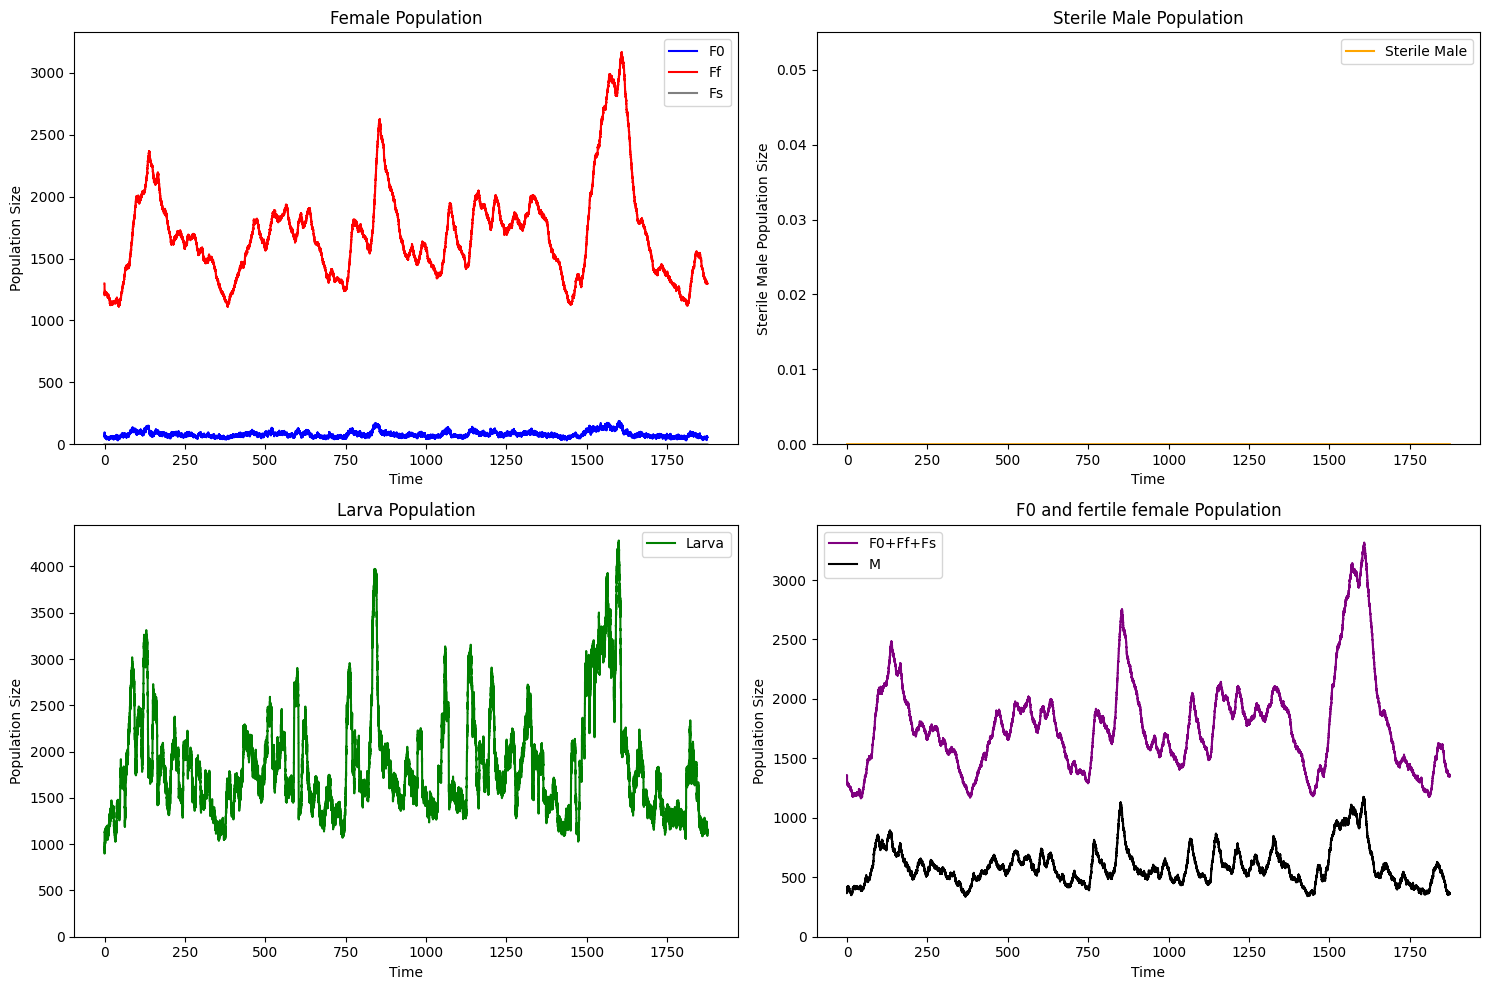

In [120]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
temp = np.interp(np.array(time_history), time_data, temperature_data)

# Sample every 10th point
step = 1000
time_sampled = time_history[::step]
pop_sampled = population_history[::step]

# Plot results for male and female population
axs[0, 0].step(time_sampled, [pop[3] for pop in pop_sampled], where="post", label='F0', color = 'blue')
axs[0, 0].step(time_sampled, [pop[4] for pop in pop_sampled], where="post", label='Ff', color = 'red')
axs[0, 0].step(time_sampled, [pop[5] for pop in pop_sampled], where="post", label='Fs', color = 'grey')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Population Size')
axs[0, 0].set_ylim(bottom=0)
axs[0, 0].set_title('Female Population')
axs[0, 0].legend()

# Plot results for sterile male population
axs[0, 1].step(time_sampled, [pop[7] for pop in pop_sampled], where="post", label='Sterile Male', color='orange')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Sterile Male Population Size')
axs[0, 1].set_ylim(bottom=0)
axs[0, 1].set_title('Sterile Male Population')
axs[0, 1].legend()

# Plot results for egg population
axs[1, 0].step(time_sampled, [pop[1] for pop in pop_sampled], where="post", label='Larva', color='green')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Population Size')
axs[1, 0].set_ylim(bottom=0)
axs[1, 0].set_title('Larva Population')
axs[1, 0].legend()

axs[1, 1].step(time_sampled, [pop[3] + pop[4] + pop[5] for pop in pop_sampled], where="post", label='F0+Ff+Fs', color='purple')
axs[1, 1].step(time_sampled, [pop[6] for pop in pop_sampled], where="post", label='M', color='black')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Population Size')
axs[1, 1].set_ylim(bottom=0)
axs[1, 1].set_title('F0 and fertile female Population')
axs[1, 1].legend()

plt.tight_layout()
plt.show()


## Only Larva

Simplified aquatic state with only larva stage with updated rates.

In [116]:
#modified rates for the model

## Only adults

Simplest model, where only adult mosquitoes are modelled. It depends on the previous rates and functions, with a square root of the female populatoin in birth.

$\beta_A(A) = \displaystyle \frac{-(\delta_L + \tau_L) + \sqrt{(\delta_L + \tau_L)^2 + 4c \beta(A) A}}{2c}$

In [117]:
# modified rates for the model

In [ ]:
pop3 = [init_f0 + init_ff, init_male, init_sterile]

In [ ]:
transiL_mod = larva_death ** 2 / (pupa_death + transi_pa)

while t < T_max:
    # Step 1: Calculate total rate
    T = np.interp(t, time_data, temperature_data) + 273.15
    precip = np.interp(t, time_data, precip2_data)
    #T = temperature_const(t) # Uncomment this line to use constant temperature
    #water = np.interp(t, time_data, H)

    comp = competition1(1/c, 1/(c * 50), precip)
    #comp = 1 /((1 /(c) * water / (max_rain) + 1/(5 * c)))
    
    if pop3[1] > 0:
        prob_M = pop3[1]/(pop3[1] + pop3[2])
    else:
        prob_M = 0

    birth_mod = birth * prob_M * allee(pop3[1], pop3[2]) * transi_el / (transi_el + egg_death)
    birth_rate = ( -(larva_death + transiL_mod) + np.sqrt((larva_death + transiL_mod)**2 + 4 * comp * birth_mod) )/ (2 * comp)
    
    total_rate = (female_death * pop3[0]+
                  male_death * pop3[1]+
                  male_death * 1.2 * pop3[2]+
                  birth_rate * pop3[0]
    )

    if total_rate == 0:
        print("No life :(")
        break
    
    # Step 2: Draw time to next event
    time_to_next_event = np.random.exponential(1 / total_rate)
    t += time_to_next_event

    # Step 4: Determine the event
    p = np.random.rand() * total_rate
    if p < (female_death * pop3[0]):
        pop3[0] -= 1
    elif p < (female_death * pop3[0] + male_death * pop3[1]):
        pop3[1] -= 1
    elif p < (female_death * pop3[0] + male_death * pop3[1] + male_death * 1.2 * pop3[2]):
        pop3[2] -= 1
    else:
        pop3[0] += n_egg/2
        pop3[1] += n_egg/2


    # Step 3: Sterile insect release
    is_release_day = int(t) % 7 == 0
    is_new_day     = int(time_history[-1]) != int(t)
    enough_females = pop[4] + pop[5] > 30
    after_start    = t > 250
    releases_left  = n_rel < 20

    if is_release_day and is_new_day and enough_females and after_start and releases_left:
        nb = max(10000,release1(pop[6], 100))
        pop[7] += nb
        n_rel += 1
        print(f"Release {n_rel} at t={t:.2f}: {nb} sterile males")


    # Step 5: Record history
    time_history.append(t)
    population_history.append((pop3[0], pop3[1], pop3[2]))
    if sum(pop3) == 0 or pop3[1] + pop3[2] == 0:
        print("No life :(")
        break
    
    if min(pop3) < 0:
        print("Negative population :(")
        break
